# Conversation-Connect
### Identifying patients for Serious Illness Conversations

> Corey Chivers, PhD <corey.chivers@pennmedicine.upenn.edu> <br>
> Copyright (c) 2019 University of Pennsylvania Health System, MIT License

Predict risk of 6 month mortality for a general population of Penn Medicine Oncology adult patients to improve access to advanced care planning for those most likely to benefit.

In [1]:
%pylab inline

import pandas as pd

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
enc_data = pd.read_csv('OutpatientONC_v1_1_enc_data_features.csv')

/Users/cchivers/anaconda2/envs/ps_pipeline/lib/python2.7/site-packages/pandas/io/parsers.py:1139: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])
enc_data['APPT_TIME'] = pd.to_datetime(enc_data['APPT_TIME'])

In [4]:
res2 = enc_data

In [5]:
np.random.seed(123456)

## Randomly sample one encounter per EMPI
idx = list(res2.index)
np.random.shuffle(idx)
res2 = res2.iloc[idx,:].drop_duplicates('EMPI')
##

label_name = 'label'

res2.index = range(res2.shape[0])
EMPIs = res2['EMPI'].unique()

prop_train = 0.7
n_train = int(len(EMPIs) * prop_train)

print(n_train, len(EMPIs) - n_train)

np.random.shuffle(EMPIs)
train_empis = EMPIs[:n_train]
test_empis = EMPIs[n_train:]
train_idx = res2['EMPI'].isin(train_empis)
test_idx = res2['EMPI'].isin(test_empis)

train = res2[train_idx]
test = res2[test_idx]

train_idx.sum(), test_idx.sum()

18567 7958


(18567, 7958)

In [6]:
train[label_name].mean(), test[label_name].mean(), 

(0.038509182959013302, 0.043980899723548628)

In [7]:
train[label_name].sum(), test[label_name].sum(), 

(715, 350)

In [8]:
num_cols = [c for c in enc_data if ': ' in c]
dx_cols = [c for c in enc_data if c.startswith('n_')]
cat_cols = [c for c in enc_data if '>>>' in c]

In [9]:
feature_cols = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

In [10]:
in_vars = feature_cols
len(in_vars)

766

In [11]:
from sklearn import metrics

def binary_cv_metrics(y, preds, m):
    ACC = metrics.accuracy_score(y,preds)
    cm = metrics.confusion_matrix(y,preds)
    if y.mean() == 0:
        cm = np.array([[np.logical_not(preds).sum(),preds.sum()],[0,0]])
        ACC = np.logical_not(preds).mean()
    elif y.mean() == 1:
        cm = np.array([[0,0],[np.logical_not(preds).sum(),preds.sum()]])
        ACC = preds.mean()
        
    m['confusion_matrix'] = cm
    m['Accuracy'] = ACC
    m['base rate'] = y.mean()
    m['n'] = cm.sum()
    m['F1 score'] = metrics.f1_score(y,preds)
    m['FPR'] = cm[0,1]/(cm[0,:].sum()*1.0)
    m['FNR'] = cm[1,0]/(cm[1,:].sum()*1.0)
    m['Alert Rate'] = cm[:,1].sum()*1.0 / cm.sum()
    m['Specificity (TNR)'] = cm[0,0]/(cm[0,:].sum()*1.0)
    m['Sensitivity (TPR, Recall)'] = cm[1,1]/(cm[1,:].sum()*1.0)
    m['PPV (Precision)'] = cm[1,1]/(cm[:,1].sum()*1.0)
    m['NPV'] = cm[0,0]/(cm[:,0].sum()*1.0)

def cv_metrics(y,probas,m,threshold=0.5):
    '''Collect performance metrics'''
    preds = probas >= threshold

    fpr, tpr, thresholds = metrics.roc_curve(y, probas)
    try:
        AUC = metrics.auc(fpr, tpr)
        m['AUC'] = AUC
    except:
        m['AUC'] = np.nan
        
    binary_cv_metrics(y, preds, m)

import ps_analysis_utils
reload(ps_analysis_utils)

/Users/cchivers/anaconda2/envs/ps_pipeline/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ps_analysis_utils' from 'ps_analysis_utils.pyc'>

In [12]:
def plot_perf(clf, in_vars, test,label_name='label',plt_cal=True, logistic=False):  
    if logistic:
        test['Pred'] = result.predict(test[in_vars])
    else:
        test['Pred'] = clf.predict_proba(test[in_vars])[:,1]

    preds = test['Pred'].values
    preds = np.array([preds,preds]).T
    ms = []
    threshes = np.linspace(0,test['Pred'].max(),100)
    for thresh in threshes:
        m = {}
        criteria = test['Pred'] > thresh
        binary_cv_metrics(test[label_name],criteria ,m)
        m['threshold'] = thresh
        ms.append(m)
    ms_df = pd.DataFrame(ms)

    fig, ax = plt.subplots(2,1,figsize=(8,8))
    for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
        ax[0].plot(threshes,ms_df[metric],'-',label=metric)
    ax[0].legend(loc=0)

    ps_analysis_utils.plt_auc(preds,test[label_name],ax=ax[1])
    
    if plt_cal:
        ps_analysis_utils.plot_calibration_curve_error_bars(test[label_name],test['Pred'],n_bins=10)
    
    plt.show()
    importances = None
    if not logistic:
        importances = pd.DataFrame([{'importance':m,'var':in_vars[e]} for e,m in enumerate(clf.feature_importances_)])
        importances = importances.sort('importance',ascending=False).head(20)
    return importances, ms_df

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200,criterion='entropy',n_jobs=4)
clf.fit(train[in_vars],train['label'])

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0)

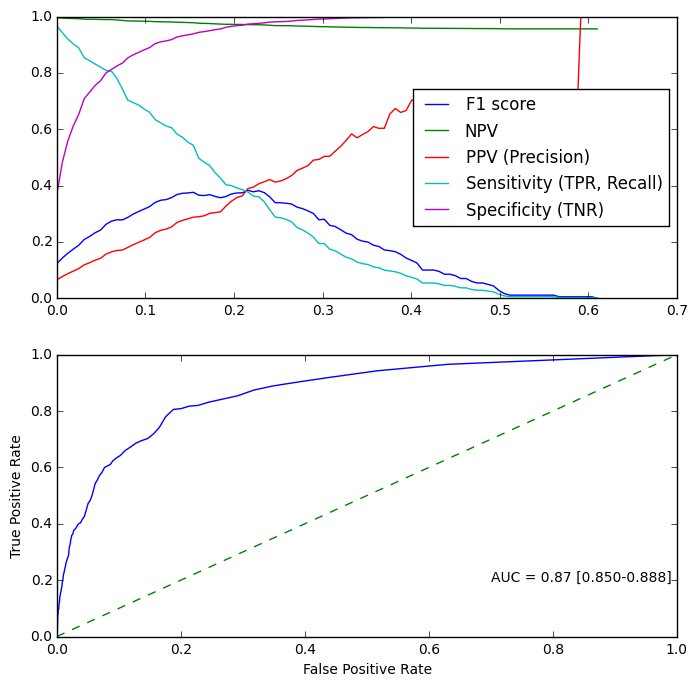

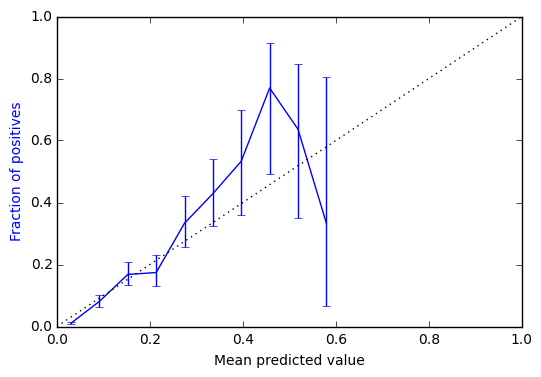

,importance,var
764,0.051817,PAT_AGE
54,0.021105,n_Tumor
55,0.014995,n_Tumor_recent
1,0.011103,n_METS_recent
0,0.011096,n_METS
290,0.010976,Albumin: min
288,0.010357,Albumin: last
72,0.007619,RDW: max
255,0.007550,% Lymphocytes: min
211,0.007316,Alkaline Phosphatase: last


In [14]:
importances, ms_df = plot_perf(clf, in_vars, test)
importances.sort('importance',ascending=False).head(20)

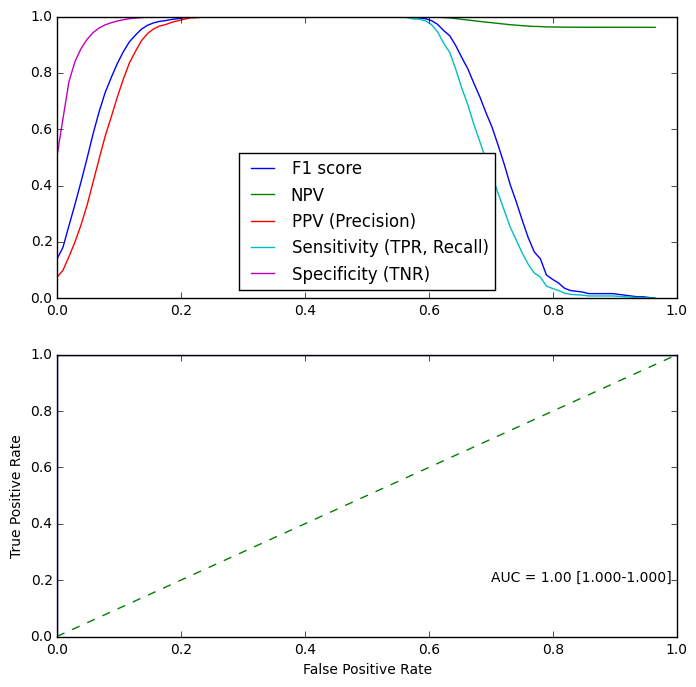

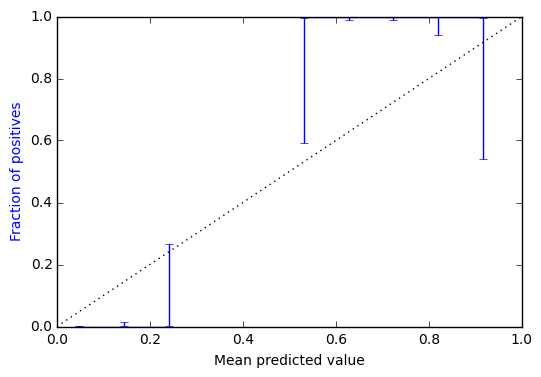

In [15]:
importances, ms_df = plot_perf(clf, in_vars, train)

# Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(verbose=1, subsample=0.9)

In [17]:
def monitor(i, clf, local_vars):
    if i > 150:
        return True
    else:
        return False

In [18]:
DAYS_IN_NS = 8.64e+13
test['label2'] = (test['DEATH_DATE'] - test['APPT_TIME']) < (30 * 12 * DAYS_IN_NS)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3033           0.0198            2.87m
         2           0.2941           0.0104            2.08m
         3           0.2859           0.0062            1.89m
         4           0.2760           0.0067            1.69m
         5           0.2741           0.0041            1.59m
         6           0.2640           0.0045            1.53m
         7           0.2614           0.0023            1.44m
         8           0.2637           0.0018            1.37m
         9           0.2569           0.0021            1.35m
        10           0.2593           0.0024            1.44m
        20           0.2383           0.0006            1.22m
        30           0.2269          -0.0001           59.92s
        40           0.2186          -0.0003           46.47s
        50           0.2111          -0.0003           36.28s
        60           0.2041          -0.0002           27.43s
       

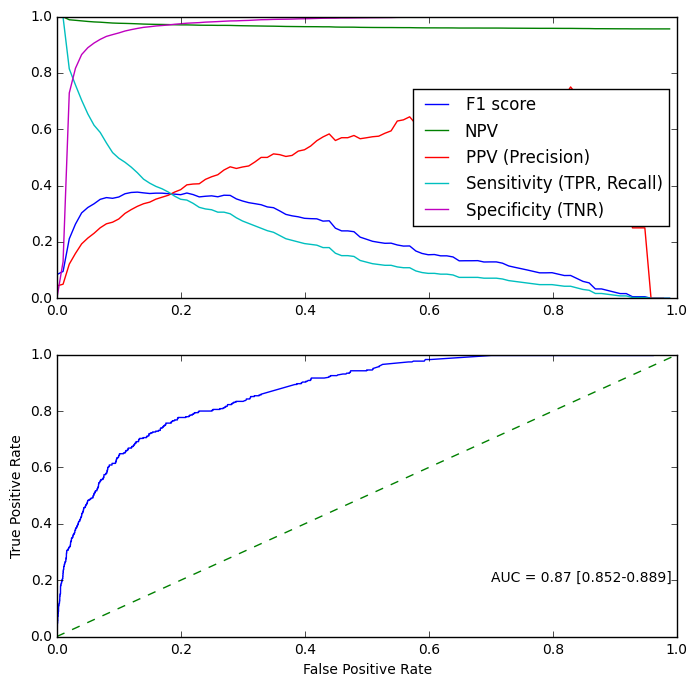

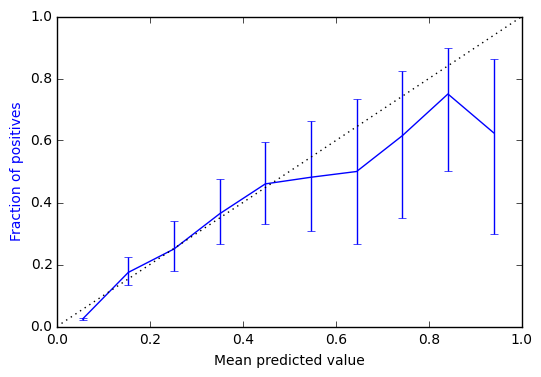

In [19]:
in_vars = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

# in_vars = [c for c in in_vars if (': count' not in c) and \
#            (': std' not in c) and \
#            (': prop STAT ordered' not in c)]

# for i,c in enumerate(in_vars):
#     if 'n_' in c and '_recent' not in c:
#         in_vars.pop(i)

clf.fit(train[in_vars],train['label'])#, monitor=monitor)
importances, ms_df = plot_perf(clf, in_vars, test)
# importances
# _ = plot_perf(clf, in_vars, test,label_name='label2')


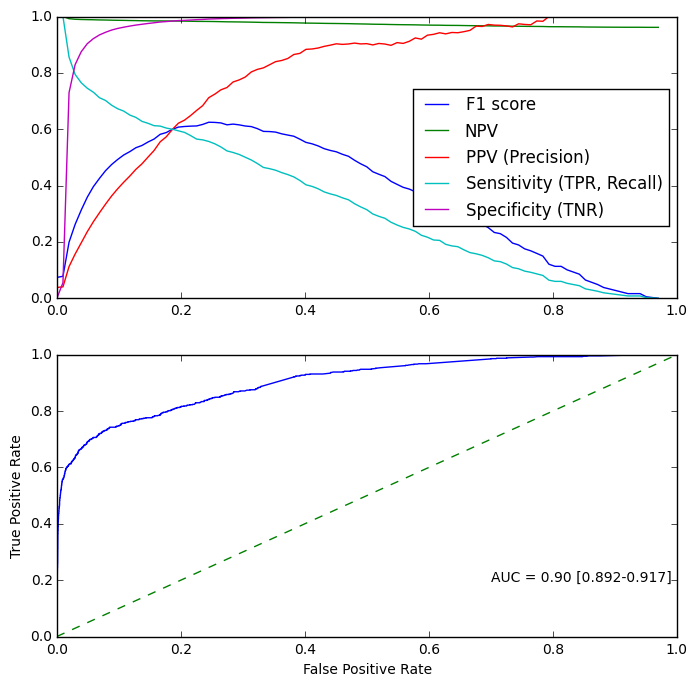

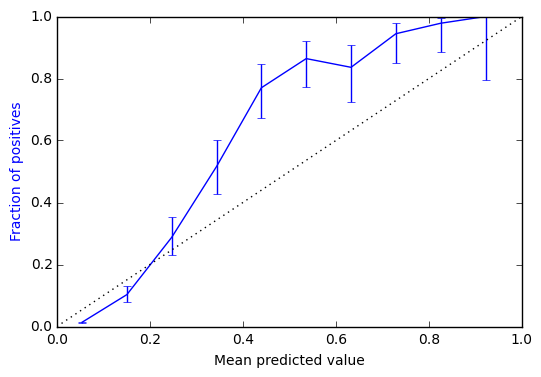

In [20]:
importances, ms_df = plot_perf(clf, in_vars, train)

In [21]:
ms_df[(ms_df['threshold'] > 0.2) &(ms_df['threshold']<0.22)]

,Accuracy,Alert Rate,F1 score,FNR,FPR,NPV,PPV (Precision),"Sensitivity (TPR, Recall)",Specificity (TNR),base rate,confusion_matrix,n,threshold
21,0.97097,0.035870,0.609703,0.411189,0.013724,0.983576,0.632132,0.588811,0.986276,0.038509,"[[17607, 245], [294, 421]]",18567,0.205763
22,0.97167,0.034308,0.610947,0.422378,0.012548,0.983157,0.648352,0.577622,0.987452,0.038509,"[[17628, 224], [302, 413]]",18567,0.215561


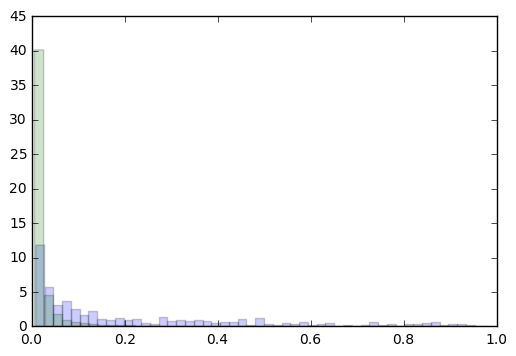

In [22]:
fig, ax = plt.subplots(1,1)
ax.hist(test[test['label'] == 1]['Pred'].values,bins=50,alpha=0.2,normed=True)
ax.hist(test[test['label'] == 0]['Pred'].values,bins=50,alpha=0.2,normed=True);
plt.show()

In [23]:
(test['label'] == 1).mean(), (test['Pred'] > 0.2).mean()

(0.043980899723548628, 0.039959788891681329)

In [5]:
#test['PROVIDER_NAME'].value_counts()

In [4]:
#test.sort('Pred').tail(20)

# Get biggest errors

To be inspected by clinical team for systematic data/model issues

In [26]:
#test[test['label'] == 0].sort('Pred').tail(20).to_csv('Palliative_Data/EoL_model_OutpatientONC_v1_1_top20false_positives.csv',index=False)
#test[test['label'] == 1].sort('Pred').head(20).to_csv('Palliative_Data/EoL_model_OutpatientONC_v1_1_top20false_negatives.csv',index=False)

subpopulation analysis for  SPECIALTY : ['Hematology/Oncology' 'Oncology']


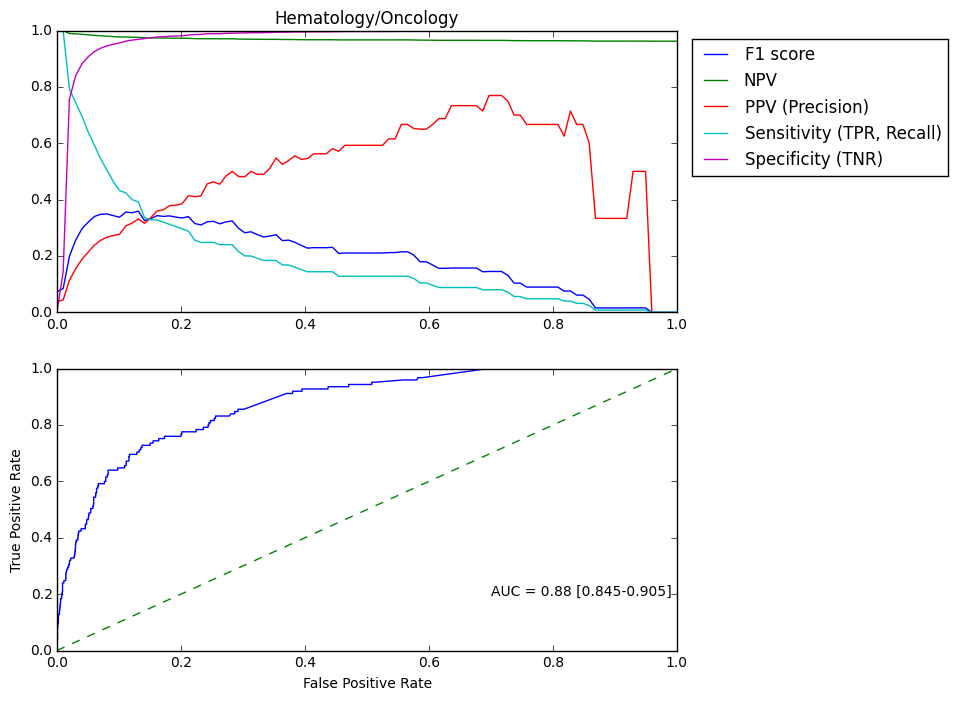

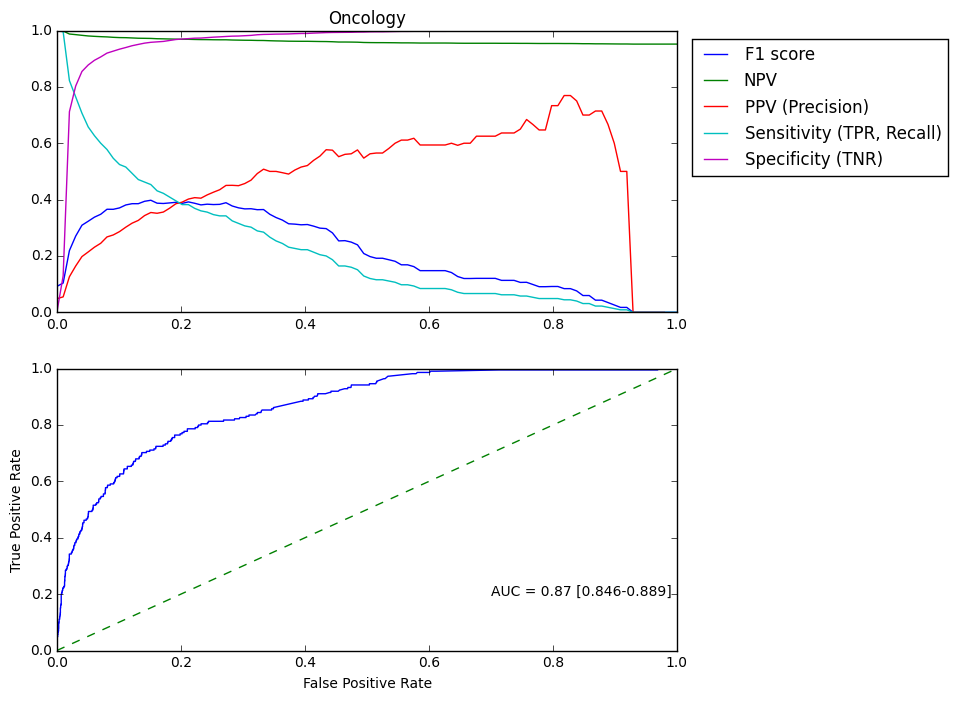

,AUC,Accuracy,Alert Rate,F1 score,FNR,FPR,NPV,PPV (Precision),"Sensitivity (TPR, Recall)",Specificity (TNR),base rate,confusion_matrix,n,threshold
Hematology/Oncology,0.876217,0.9553869,0.02913505,0.3348416,0.704,0.01861199,0.9724914,0.3854167,0.296,0.981388,0.03793627,"[[3111, 59], [88, 37]]",3295,0.2020202
Oncology,0.8680707,0.941454,0.04717993,0.3865169,0.6177778,0.03019378,0.9687148,0.3909091,0.3822222,0.9698062,0.0482522,"[[4304, 134], [139, 86]]",4663,0.2020202


In [27]:
def plt_performance(df,plot_output=True,plt_title=''):
    preds = df['Pred'].values
    preds = np.array([preds,preds]).T
    ms = []
    threshes = np.linspace(0,1,100)
    for thresh in threshes:
        m = {}
        #criteria = df['Pred'] > thresh
        cv_metrics(df[label_name],df['Pred'],m,thresh)
        #m[dx_class] = n
        m.update({'threshold':thresh})
        ms.append(m)
    ms_df = pd.DataFrame(ms)
    
    if plot_output:
        fig, ax = plt.subplots(2,1,figsize=(8,8))
        for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
            ax[0].plot(threshes,ms_df[metric],'-',label=metric)
        ax[0].legend(bbox_to_anchor=(1.45, 1.0))
        ax[0].set_title(plt_title)
        try:
            ps_analysis_utils.plt_auc(preds,df[label_name],ax=ax[1])
        except:
            pass
        plt.show()
    return ms_df


def run_categorical_subpop(df,category_var,plot_output=True,thresh=0.5):
    m_list = []
    categories = df[category_var].unique()
    print('subpopulation analysis for ',category_var, ':',categories)
    for category in categories:
        idb = df[category_var] == category
        subpop = df[idb]
        if subpop[label_name].sum() == 0 or idb.sum() < 5:
            ms_df = plt_performance(subpop,False,plt_title=category)
            #m = pd.DataFrame([{'n':idb.sum(),'base rate':0.0}])
        else:
            ms_df = plt_performance(subpop,plot_output,plt_title=category)
        m = pd.DataFrame(ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]).T
        m.index = [category]
        m_list.append(m)
    return pd.concat(m_list)


def run_numerical_subpop(df,category_var,plot_output=True,thresh=0.5):
    m_list = []
    categories = []
    n_tiles = 10
    n_tile = np.linspace(0,1,n_tiles)
    n_tile = list(df[category_var].quantile(n_tile))
    for t in range(n_tiles-1):
        idb = (df[category_var] > n_tile[t]) & (df[category_var] <= n_tile[t+1])
        categories.append({'range': "%0.0f-%0.0f"%(n_tile[t],n_tile[t+1]),
                          'idb': idb})
    
    print('subpopulation analysis for ',category_var, ':',[c['range'] for c in categories])
    for category in categories:
        idb = category['idb']
        subpop = df[idb]
        if subpop[label_name].sum() == 0 or idb.sum() < 5:
            m = pd.DataFrame([{'n':idb.sum(),'base rate':0.0}])
        else:
            ms_df = plt_performance(subpop,plot_output,plt_title=category['range'])
            m = pd.DataFrame(ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]).T
        m.index = [category['range']]
        m_list.append(m)
    return pd.concat(m_list)

#sp_age = run_numerical_subpop(test,'SPECIALTY',plot_output=False,thresh=0.3)
sp_specialty = run_categorical_subpop(test,'SPECIALTY',thresh=0.2)
sp_specialty

In [28]:
sp_specialty.T

,Hematology/Oncology,Oncology
AUC,0.876217,0.8680707
Accuracy,0.9553869,0.941454
Alert Rate,0.02913505,0.04717993
F1 score,0.3348416,0.3865169
FNR,0.704,0.6177778
FPR,0.01861199,0.03019378
NPV,0.9724914,0.9687148
PPV (Precision),0.3854167,0.3909091
"Sensitivity (TPR, Recall)",0.296,0.3822222
Specificity (TNR),0.981388,0.9698062


In [29]:
from ps_datasci.psUtilities import buffer_ylim, buffer_xlim

def plt_subpop_perf(df,title='Subgroup Performance',xlabel=''):
    first_plot_items = ['AUC','Accuracy','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']
    second_plot_items = ['base rate']
    third_plot_items = ['n']
    fig, axx = plt.subplots(3,1, sharex=True,figsize=(8,8))
    ax = axx[0]
    ax.set_title(title)
    for fp_item in first_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(bbox_to_anchor=(1.6, 1.0))
    ax.grid()
    buffer_ylim(ax,0.1)
    
    ax = axx[1]
    for fp_item in second_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(bbox_to_anchor=(1.35, 1.0))
    ax.grid()
    buffer_ylim(ax,0.1)
    
    ax = axx[2]
    for fp_item in third_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
    ax.set_xticks(range(df.shape[0]))
    ax.set_xticklabels(df.index,rotation=45,horizontalalignment='right')
    ax.set_xlabel(xlabel)
    ax.grid()
    buffer_ylim(ax,0.1)
    buffer_xlim(ax,0.05)

subpopulation analysis for  PAT_AGE : ['14-42', '42-51', '51-57', '57-61', '61-65', '65-69', '69-73', '73-79', '79-99']


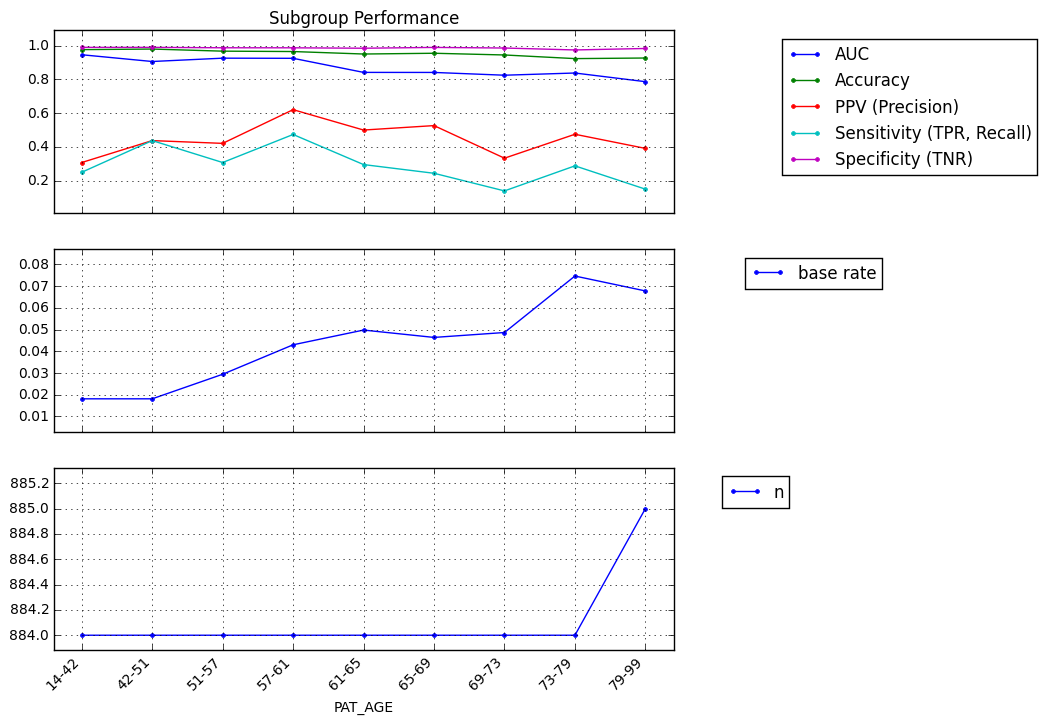

In [30]:
sp_age = run_numerical_subpop(test,'PAT_AGE',plot_output=False,thresh=0.3)
plt_subpop_perf(sp_age,xlabel='PAT_AGE');

## Logistic Regression

In [39]:
enc_data['SEX_C'].dtype

dtype('float64')

In [40]:
from sklearn.linear_model import LogisticRegression

in_vars = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

in_vars = [c for c in in_vars if (': count' not in c) and \
           (': std' not in c) and \
           (': prop STAT ordered' not in c)]

### Normalize ###
no_log_list = ['PAT_AGE','SEX_C'] + num_cols
no_norm_list = []
train_norm = train.copy()
test_norm = test.copy()
norm_dict = {}
for v in in_vars:
    if v not in no_norm_list:
        if v not in no_log_list:
            norm_dict[v+' mean'] = np.log(train[v]+1).mean()
            norm_dict[v+' std'] = np.log(train[v]+1).std()
            train_norm[v] = (np.log(train[v]+1) - norm_dict[v+' mean']) / norm_dict[v+' std']
            test_norm[v] = (np.log(test[v]+1) - norm_dict[v+' mean']) / norm_dict[v+' std']
        else:
            norm_dict[v+' mean'] = train[v].mean()
            norm_dict[v+' std'] = train[v].std()
            train_norm[v] = (train[v] - norm_dict[v+' mean']) / norm_dict[v+' std']
            test_norm[v] = (test[v] - norm_dict[v+' mean']) / norm_dict[v+' std']
    else:
        train_norm[v] = train[v]*1.0
        test_norm[v] = test[v]*1.0

In [41]:
train_norm['intercept'] = 1
test_norm['intercept'] = 1

In [42]:
last_labs = [c for c in train_norm if ': last' in c]
dx_hist = [c for c in train_norm if 'n_' in c]


In [43]:
import statsmodels.api as sm
in_vars_lr = ['intercept'] +  last_labs + dx_hist + ['PAT_AGE','SEX_C']

In [44]:
## Iterative variable selectionn
last_n_vars = 0
while len(in_vars_lr) != last_n_vars:
    last_n_vars = len(in_vars_lr)
    print(last_n_vars)
    logit = sm.Logit(train_norm[label_name],train_norm[in_vars_lr])
    result = logit.fit()
    in_vars_lr = result.pvalues.index[result.pvalues < 0.1]
    
print(result.summary())

165
Optimization terminated successfully.
         Current function value: 0.117934
         Iterations 14
39
Optimization terminated successfully.
         Current function value: 0.124342
         Iterations 9
36
Optimization terminated successfully.
         Current function value: 0.124469
         Iterations 9
35
Optimization terminated successfully.
         Current function value: 0.124520
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                18567
Model:                          Logit   Df Residuals:                    18532
Method:                           MLE   Df Model:                           34
Date:                Fri, 05 Apr 2019   Pseudo R-squ.:                  0.2369
Time:                        14:36:35   Log-Likelihood:                -2312.0
converged:                       True   LL-Null:                       -3029.7
                         

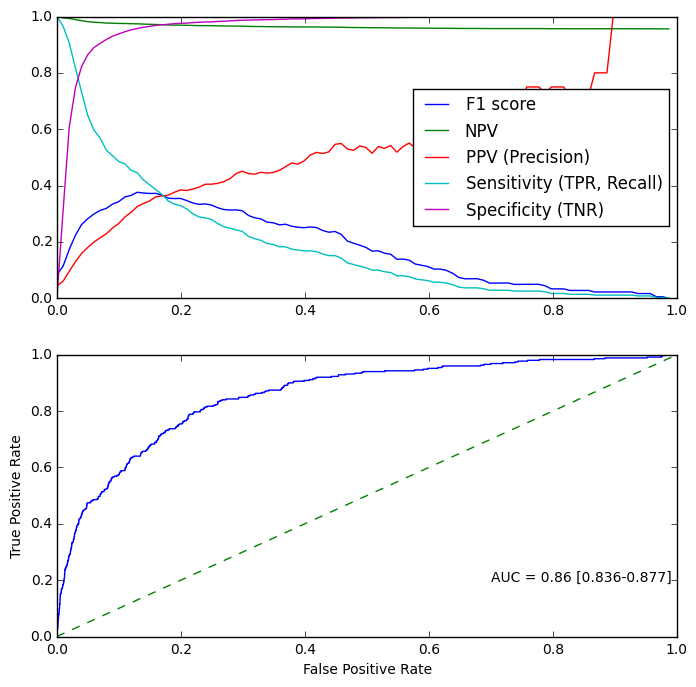

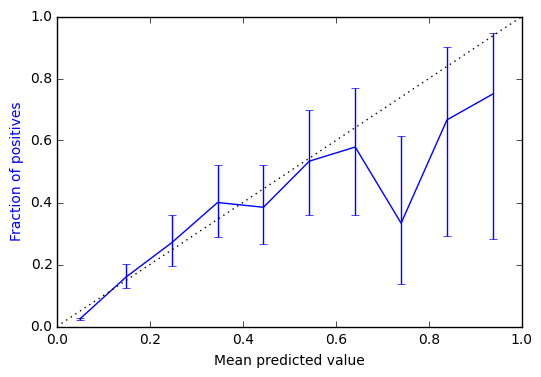

In [45]:
importances, ms_df = plot_perf(result, in_vars_lr, test_norm, logistic=True)

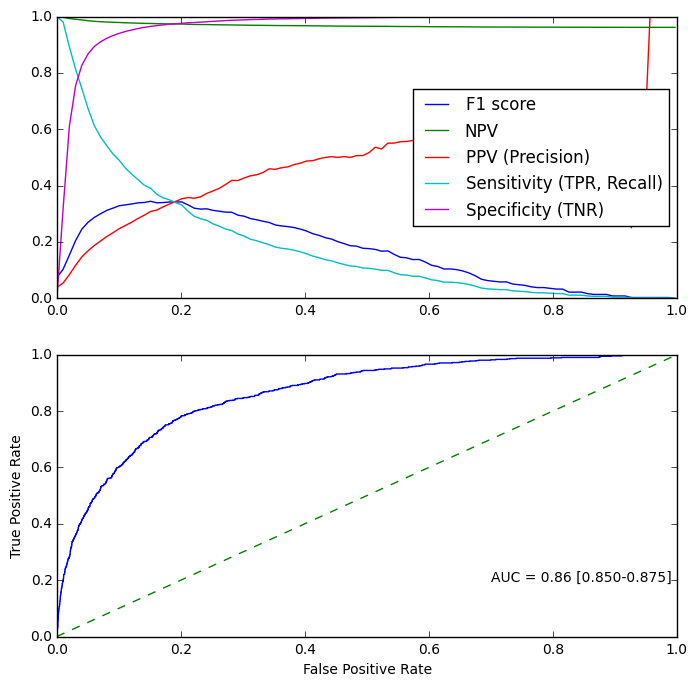

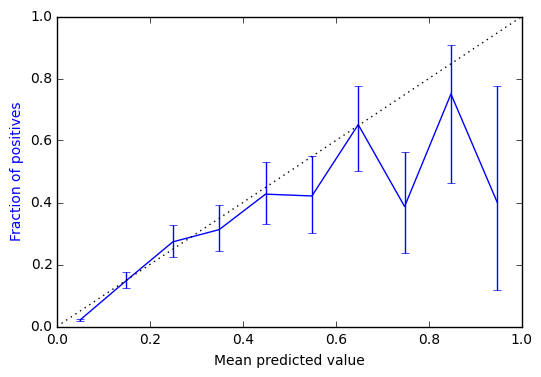

In [46]:
importances, ms_df = plot_perf(result, in_vars_lr, train_norm, logistic=True)

In [47]:
ms_df[(ms_df['threshold'] > 0.3) &(ms_df['threshold']<0.33)]

,Accuracy,Alert Rate,F1 score,FNR,FPR,NPV,PPV (Precision),"Sensitivity (TPR, Recall)",Specificity (TNR),base rate,confusion_matrix,n,threshold
30,0.958582,0.019928,0.291244,0.779021,0.011875,0.969391,0.427027,0.220979,0.988125,0.038509,"[[17640, 212], [557, 158]]",18567,0.302113
31,0.959067,0.018581,0.283019,0.790210,0.010923,0.968994,0.434783,0.209790,0.989077,0.038509,"[[17657, 195], [565, 150]]",18567,0.312183
32,0.959283,0.017935,0.278626,0.795804,0.010475,0.968795,0.438438,0.204196,0.989525,0.038509,"[[17665, 187], [569, 146]]",18567,0.322254


In [48]:
## LR "Importance" & direction
pv = pd.DataFrame(result.pvalues).sort(0)
pd.DataFrame(result.tvalues[pv.index])

,0
intercept,-65.132062
Albumin: last,-10.250277
n_Tumor_recent,10.022118
n_METS_recent,8.525422
PAT_AGE,8.389282
Alkaline Phosphatase: last,5.621641
SEX_C,5.547985
n_Tumor,-5.059770
n_BLA,5.026847
Red Blood Cells: last,-5.004892


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3073           0.0135            3.89m
         2           0.2963           0.0089            2.75m
         3           0.2836           0.0059            2.12m
         4           0.2742           0.0057            1.82m
         5           0.2722           0.0021            1.70m
         6           0.2692           0.0033            1.57m
         7           0.2616           0.0021            1.52m
         8           0.2603           0.0006            1.47m
         9           0.2570           0.0015            1.40m
        10           0.2537           0.0007            1.38m
        20           0.2362           0.0006            1.10m
        30           0.2230          -0.0003           53.71s
        40           0.2143           0.0002           43.13s
        50           0.2086           0.0001           34.22s
        60           0.2012          -0.0003           27.00s
       

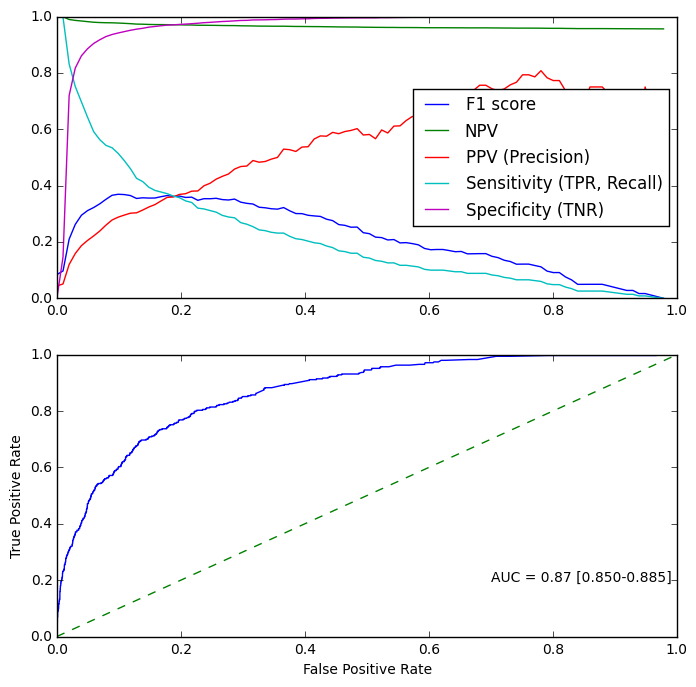

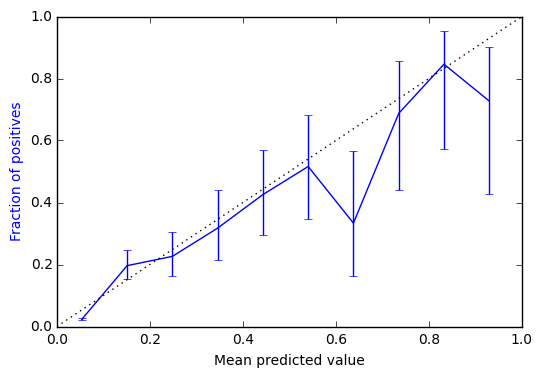

612
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3056           0.0113            4.61s
         2           0.2937           0.0082            3.33s
         3           0.2856           0.0048            2.88s
         4           0.2835           0.0034            2.62s
         5           0.2704           0.0036            2.42s
         6           0.2682           0.0017            2.27s
         7           0.2674           0.0021            2.17s
         8           0.2618           0.0017            2.11s
         9           0.2604           0.0012            2.07s
        10           0.2588           0.0016            2.07s
        20           0.2431           0.0000            1.76s
        30           0.2308          -0.0003            1.52s
        40           0.2248          -0.0002            1.36s
        50           0.2196          -0.0002            1.11s
        60           0.2174          -0.0005            0.93s
   

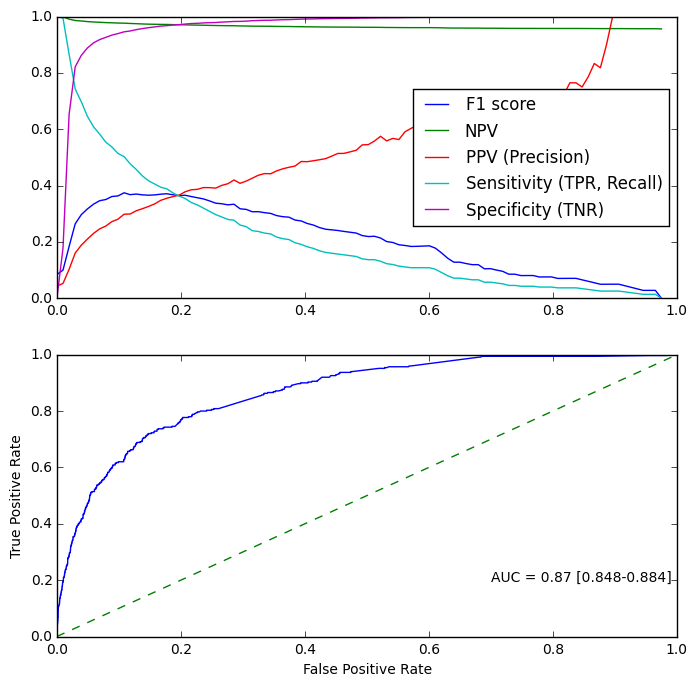

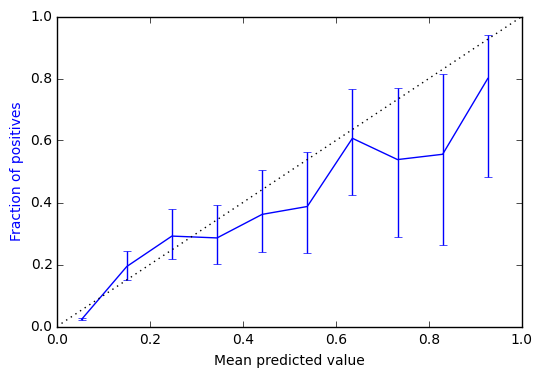

459
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3077           0.0183            4.73s
         2           0.2919           0.0077            3.90s
         3           0.2788           0.0071            3.51s
         4           0.2770           0.0060            3.15s
         5           0.2807           0.0027            2.90s
         6           0.2734           0.0030            2.71s
         7           0.2722           0.0010            2.54s
         8           0.2607           0.0021            2.43s
         9           0.2647           0.0001            2.35s
        10           0.2621           0.0015            2.34s
        20           0.2419          -0.0001            2.01s
        30           0.2354          -0.0005            1.80s
        40           0.2249          -0.0003            1.40s
        50           0.2206          -0.0003            1.10s
        60           0.2147          -0.0008            0.87s
   

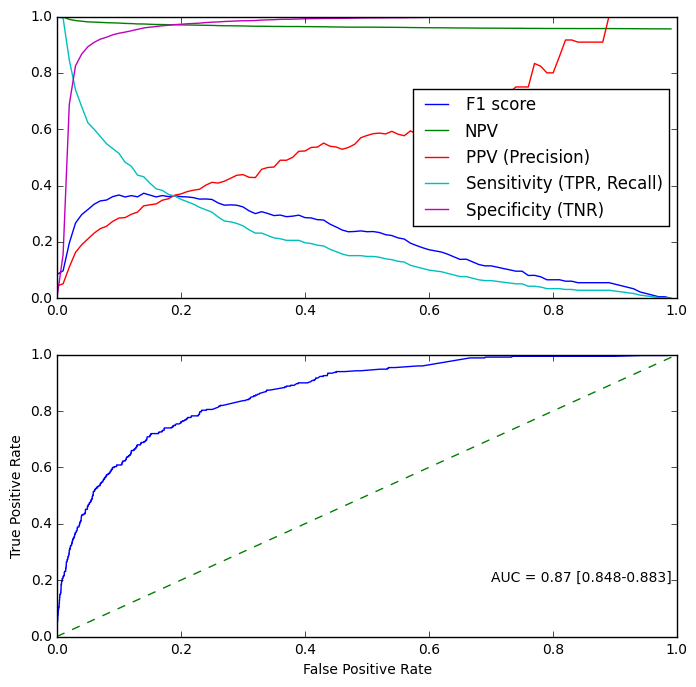

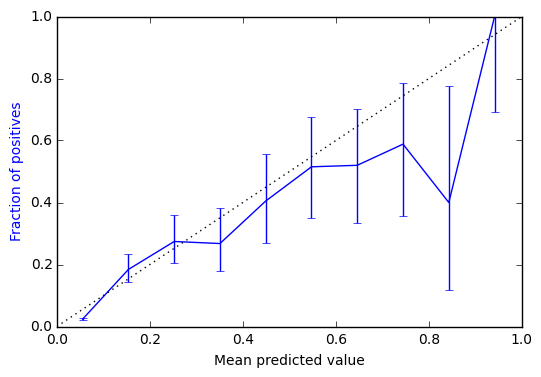

306
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3097           0.0140            5.30s
         2           0.2981           0.0078            4.31s
         3           0.2819           0.0078            3.95s
         4           0.2840           0.0055            3.51s
         5           0.2768           0.0027            3.19s
         6           0.2708           0.0027            2.93s
         7           0.2659           0.0030            2.71s
         8           0.2615           0.0018            2.55s
         9           0.2620           0.0012            2.43s
        10           0.2573           0.0004            2.38s
        20           0.2440           0.0001            1.92s
        30           0.2334          -0.0000            1.60s
        40           0.2324           0.0000            1.28s
        50           0.2267           0.0000            1.06s
        60           0.2200          -0.0001            0.83s
   

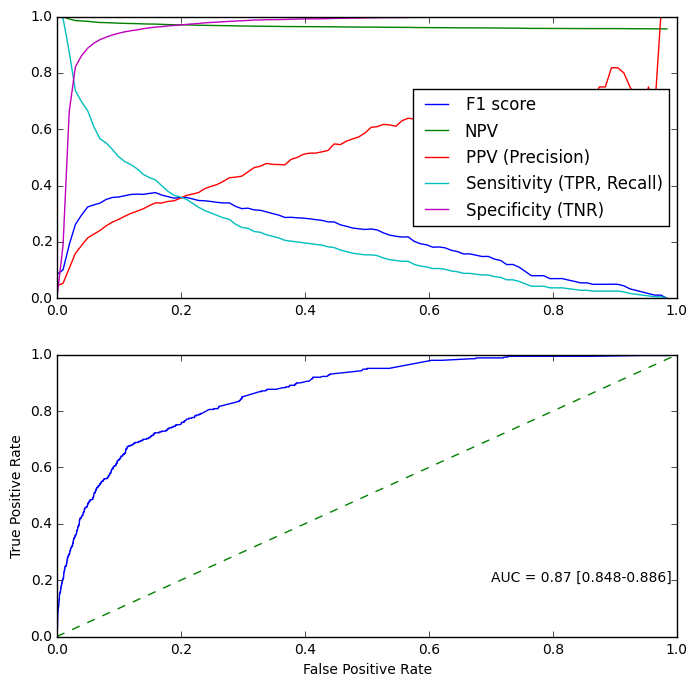

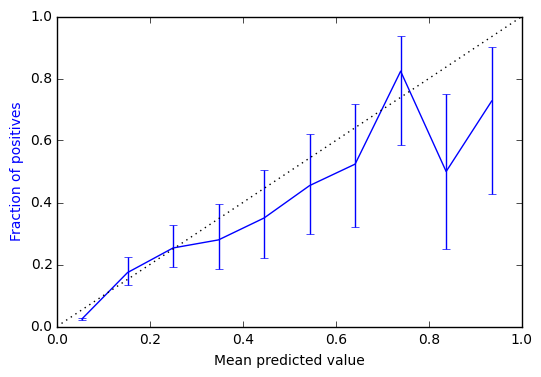

153
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.3047           0.0201            4.82s
         2           0.2921           0.0105            3.81s
         3           0.2876           0.0084            3.48s
         4           0.2760           0.0059            3.23s
         5           0.2753           0.0036            3.00s
         6           0.2685           0.0032            2.82s
         7           0.2650           0.0034            2.71s
         8           0.2596           0.0012            2.60s
         9           0.2619           0.0007            2.51s
        10           0.2572           0.0020            2.51s
        20           0.2416           0.0013            1.97s
        30           0.2347           0.0001            1.67s
        40           0.2324          -0.0005            1.41s
        50           0.2248          -0.0003            1.19s
        60           0.2164          -0.0002            0.94s
   

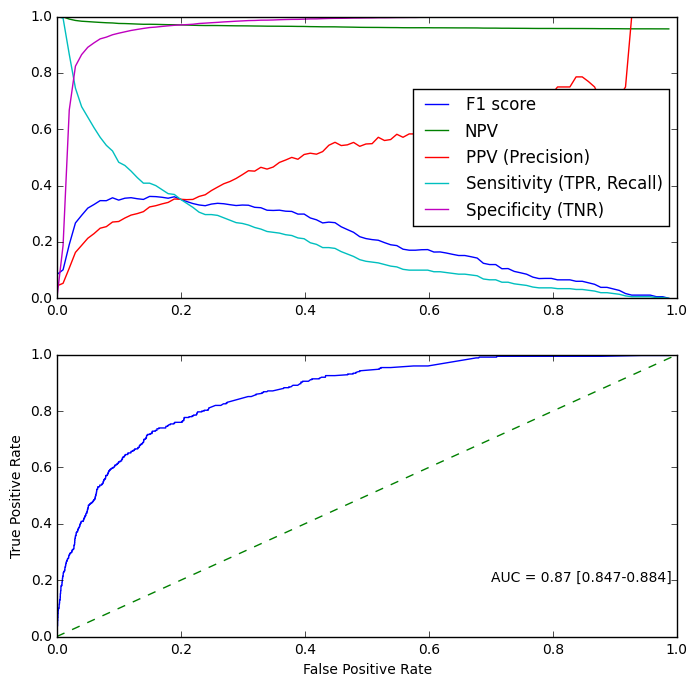

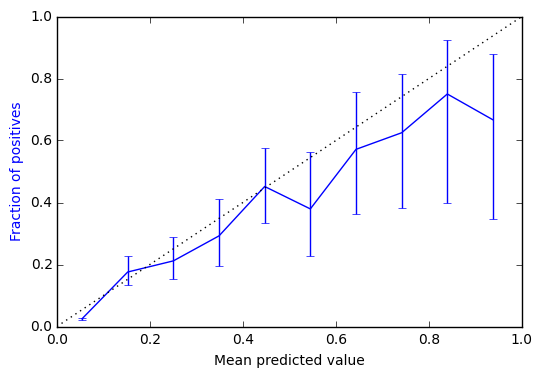

0


In [49]:
in_vars = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

for top_n in [int(len(in_vars)*p) for p in np.linspace(0.8,0,5)]:
    
    clf.fit(train[in_vars],train['label'], monitor=monitor)
    
    plot_perf(clf, in_vars, test.head(50000))
    print(top_n)
    importances = pd.DataFrame([{'importance':m,'var':in_vars[e]} for e,m in enumerate(clf.feature_importances_)])
    importances = importances.sort('importance',ascending=False).head(20)
    in_vars = list(importances.head(top_n)['var'].values)

In [50]:
importances

,importance,var
0,0.092122,Alkaline Phosphatase: last
1,0.075682,PAT_AGE
2,0.068068,Platelets: last
5,0.062282,% Neutrophils: last
6,0.059377,n_Tumor_recent
11,0.058069,Albumin: last
9,0.057782,ALT: min
8,0.055196,Chloride: last
3,0.052838,% Lymphocytes: last
16,0.050877,n_METS_recent


In [ ]:
def biplot_model_explainer(resolution_steps = 40, background_sampling = True, bootstraps = 100, aggfunc=np.mean,
                           n_vars_to_plot=5):
    feature_range_dict = {}
    for f in in_vars:
        rd = {}
        if '>>' in f:
            rd['mean'] = test[f].mean()
            rd['min'] =  test[f].min()
            rd['max'] =  test[f].max()
        else:
            rd['mean'] = test[f].median()
            rd['min'] =  np.percentile(test[f],5)
            rd['max'] =  np.percentile(test[f],95)
        feature_range_dict[f] = rd

    mean_dict = {f:v['mean'] for f,v in feature_range_dict.iteritems()}
    plt_vars = list(importances.sort('importance',ascending=False).head(n_vars_to_plot)['var'].values)
    #n_vars_to_plot = len(plt_vars)
    ylim_diag = np.percentile(test['Pred'],[1,99])
    
    fig, ax = plt.subplots(n_vars_to_plot,n_vars_to_plot,figsize=(6,6))
    for i,f1 in enumerate(plt_vars):
        j = i - 1
        for f2 in plt_vars[i:]:
            j += 1
            f_list = []
            pixel_index = 0
            for f1_val in np.linspace(feature_range_dict[f1]['min'],feature_range_dict[f1]['max'],resolution_steps):
                for f2_val in np.linspace(feature_range_dict[f2]['min'],feature_range_dict[f2]['max'],resolution_steps):
                    f_dict = {}
                    if not background_sampling:
                        f_dict = mean_dict.copy()
                        bootstraps = 1
                    for b in range(bootstraps):
                        f_dict[f1] = f1_val
                        f_dict[f2] = f2_val
                        f_dict['pixel_index'] = pixel_index
                        f_list.append(f_dict.copy())
                    pixel_index += 1

            df_space = pd.DataFrame(f_list)
            if background_sampling:
                # sampling
                rnd_idx = np.random.choice(test.index, len(f_list),replace=True)
                rnd_vars = [v for v in in_vars if v not in [f1,f2]]
                tmp = test[rnd_vars].ix[rnd_idx]
                tmp.index = df_space.index
                df_space[rnd_vars] = tmp

            preds = clf.predict_proba(df_space[in_vars])
            df_space['preds'] = preds[:,1]
            preds = df_space.pivot_table(index='pixel_index',values='preds',aggfunc=aggfunc)
            preds_mat = preds.reshape(resolution_steps,resolution_steps)
            if i == j:
                ax[i,j].plot(range(resolution_steps),preds_mat.mean(0),'-',color='black')
                ax[i,j].set_xlim(-0.5,resolution_steps-0.5)
                ax[i,j].set_ylim(ylim_diag)
                
                #ax[i,j].axis('off')
                ax[i,j].set_xticks([0,resolution_steps-1])
                ax[i,j].set_xticklabels(["%0.2f"%feature_range_dict[f1]['min'],"%0.2f"%feature_range_dict[f1]['max']],
                                       rotation=45, ha = "right",fontsize='x-small')
                ax[i,j].set_yticks([])
                ax[i,j].set_yticklabels([])
                ax[i,j].set_frame_on(False)
                ax[i,j].tick_params(length= 0)
            else:
                # flip the array so that y-dim goes high to low (top to bottom)
                preds_mat = np.flipud(preds_mat)
                ax[i,j].matshow(preds_mat) #,cmap='inferno','viridis','magma'
                ax[i,j].axis('off')
                ax[i,j].set_aspect('equal')
        for j in range(i):
            ax[i,j].axis('off')
    for i in range(n_vars_to_plot):
        if i == 0:
            ax[0][i].text(x = resolution_steps/2.0, y = ylim_diag[1]-ylim_diag[0], s = plt_vars[i], rotation = 45, va = "bottom")
        else:
            ax[0][i].text(x = resolution_steps/2.0, y = -1, s = plt_vars[i], rotation = 45, va = "bottom")

    for i in range(n_vars_to_plot):
        if i == (n_vars_to_plot -1):
            ax[i][n_vars_to_plot-1].text(x = resolution_steps, y = (ylim_diag[1]-ylim_diag[0])/2.0, s = plt_vars[i], ha = "left")
        else:
            ax[i][n_vars_to_plot-1].text(x = resolution_steps, y = resolution_steps/2.0 , s = plt_vars[i], ha = "left")
    fig.subplots_adjust(wspace = 0.1, hspace = 0.01)

In [ ]:
biplot_model_explainer(resolution_steps=10, background_sampling=True, bootstraps=100,aggfunc=np.mean,n_vars_to_plot=7)

In [ ]:
biplot_model_explainer(resolution_steps=10, background_sampling=True, bootstraps=1000,aggfunc=np.mean,n_vars_to_plot=7)